# UC SD Micromasters - Python for Data Science
# Craigslist Used Cars Dataset



In [1]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Import and read dataset

First, look at downloaded file from https://www.kaggle.com/austinreese/craigslist-carstrucks-data/download.

In [ ]:
from subprocess import check_output
print(check_output(["ls", "./data"]).decode("utf8"))

Unzip the file and extract into the data folder.

In [ ]:
# how to from https://www.kaggle.com/mchirico/how-to-read-datasets
import zipfile
Dataset = "craigslist-carstrucks-data"

with zipfile.ZipFile("./data/"+Dataset+".zip","r") as z:
    z.extractall("./data")

Import data as pandas dataframe.

In [2]:
cars_raw = pd.read_csv("./data/vehicles.csv")

In [4]:
# dataframe shape
print("Number of rows:",cars_raw.shape[0])
print()
print("Number of columns",cars_raw.shape[1])

Number of rows: 539759

Number of columns 25


## Clean data set

Remove unnecessary columns and null values. Let's look at the proportion of no-null values as percent of total number of rows. This will give us an idea of which variables contain actual data vs those that are mostly `NULL`

In [5]:
no_null_prc = (cars_raw.count()/len(cars_raw)).round(2)*100
no_null_prc

id              100.0
url             100.0
region          100.0
region_url      100.0
price           100.0
year            100.0
manufacturer     96.0
model            99.0
condition        56.0
cylinders        60.0
fuel             99.0
odometer         82.0
title_status     99.0
transmission     99.0
vin              58.0
drive            71.0
size             31.0
type             73.0
paint_color      68.0
image_url       100.0
description     100.0
county            0.0
state           100.0
lat              98.0
long             98.0
dtype: float64

Select columns of interest that have greater than 80% of actual data.

In [6]:
cols_to_use = list(no_null_prc[no_null_prc>=80].index)
cols_to_use

['id',
 'url',
 'region',
 'region_url',
 'price',
 'year',
 'manufacturer',
 'model',
 'fuel',
 'odometer',
 'title_status',
 'transmission',
 'image_url',
 'description',
 'state',
 'lat',
 'long']

Remove the first 4 columns: these columns only contain the id and other url information. Not needed for this analysis.

In [7]:
cols_not_needed = list(cars_raw.columns[0:4])
cols_not_needed.extend(['description','image_url'])
cols_not_needed

['id', 'url', 'region', 'region_url', 'description', 'image_url']

In [8]:
cars = cars_raw[[name for name in cols_to_use if name not in cols_not_needed]]
cars = cars.dropna()
cars.sample(10)

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,state,lat,long
313508,0,2002.0,ford,ranger,gas,167012.0,clean,automatic,or,45.3754,-122.6020
227162,6950,2007.0,toyota,4runner sr5,gas,174036.0,clean,automatic,ny,40.9262,-72.6520
431661,1995,2002.0,nissan,maxima,gas,138274.0,clean,automatic,pa,40.0293,-74.9497
480794,33995,2014.0,chevrolet,silverado 3500hd work,diesel,144423.0,clean,automatic,az,35.1900,-111.6660
260907,15500,2016.0,chevrolet,equinox,gas,12217.0,clean,automatic,mi,42.7683,-84.4227
382856,58949,2019.0,ford,super duty f-350 srw lariat,gas,17363.0,clean,automatic,id,43.5916,-116.3900
264051,39040,2017.0,gmc,yukon,gas,63000.0,clean,automatic,ok,35.2204,-97.4577
430906,31750,2016.0,toyota,4runner sr5 premium,gas,46000.0,clean,automatic,or,44.0223,-121.2990
51277,2988,1999.0,gmc,yukon,gas,329700.0,clean,automatic,wa,46.5803,-120.4930
352334,12489,2016.0,toyota,corolla,gas,30511.0,clean,automatic,oh,40.9035,-81.4333


In [9]:
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 405819

Number of columns 11


### Description of the variables:

Categorical variables:
- manufacturer
- model
- fuel
- title_status
- transmission
- state

Numerical variables:
- price
- year
- odometer

Location variables:
- lat
- long

Date variables:
- year

## Preliminary data exploration and further cleaning

Firts, lets look at the distribution of the numeric variables : 

- Median price is \$10900 while the max value is $4.3 billion!
- Medin odometer reading is 93827 mi.
- Median year is 2012

Here are some more additiona statistics.

In [10]:
cars.describe(percentiles=[0.05,0.1,0.5,0.9,0.95]).transpose()

,count,mean,std,min,5%,10%,50%,90%,95%,max
price,405819.0,158396.881410,2.055869e+07,0.0000,0.0000,1750.0000,10900.0000,27988.0000,34000.0000,4.198287e+09
year,405819.0,2010.920068,6.819119e+00,1908.0000,2000.0000,2003.0000,2012.0000,2017.0000,2018.0000,2.021000e+03
odometer,405819.0,100039.416912,1.026830e+05,0.0000,12434.9000,23089.0000,93827.0000,178079.4000,203560.0000,1.000000e+07
lat,405819.0,38.687136,5.785775e+00,-84.9114,28.6036,30.6007,39.2868,45.4881,47.6496,8.451480e+01
long,405819.0,-94.201507,1.781262e+01,-166.3770,-122.5380,-121.3020,-88.0490,-74.8883,-73.0805,1.610160e+02


### Price and Odometer

Remove vehicles with prices and odometer readings that are slightly more than the 90% percentile and less than the 1% percentile. This will get rid of extreme outliers. 

In [11]:
cars = cars[(cars.price<=30000) & (cars.price>1000) & (cars.odometer<=180000) &  (cars.odometer>=2000)]

# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 298421

Number of columns 11


Let's look at a plot of a joint histogram using exagonal bins of the price with odometer reading: notice the down-ward non-linear nature of of the data.

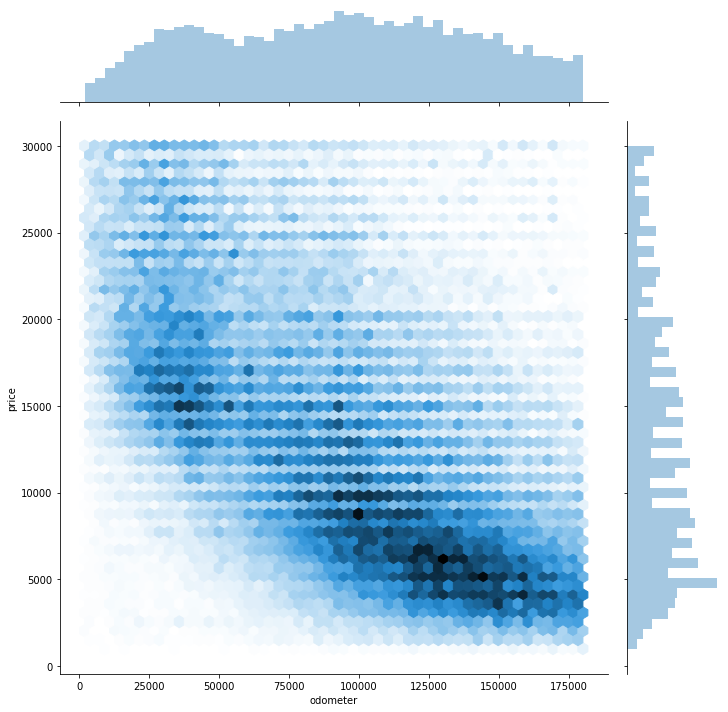

In [12]:
sns.jointplot("odometer", "price", data=cars,size=10,kind = "hex");

### Transmission

A large majority of values in transmission are laballed as  "other":

In [13]:
cars.transmission.value_counts()

automatic    264175
other         18398
manual        15848
Name: transmission, dtype: int64

We'll assume transmission labeled "other" is automatic:

In [14]:
cars['transmission'] = np.where(cars.transmission == "other","automatic",cars.transmission)

Now let's look at the boxplot of transmission type vs price. Notice that vehicles with an automatic transmission tend to be at slightly higher price:

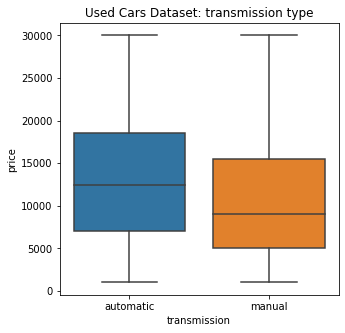

In [15]:
plt.figure(figsize=(5,5))
sns.boxplot(x='transmission',y='price',data=cars).set_title('Used Cars Dataset: transmission type');

### Title Status

A very small minority of `title_status` values are either labeled "missing" or "parts only". So we'll remove those variables from the dataset.

In [16]:
cars.title_status.value_counts()

clean         284895
rebuilt         8434
salvage         3186
lien            1780
missing           95
parts only        31
Name: title_status, dtype: int64

In [17]:
# remove 'missing' and 'parts only'
keep = ['clean','rebuilt','salvage','lien']
cars = cars[cars['title_status'].isin(keep)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 298295

Number of columns 11


Now let's look a the boxplot of title status vs price. Interestingly, vehicles with a lien tend to be higher priced. This could be because those vehicles typically are being sold to pay off creditors (banks, dealerships, etc.)

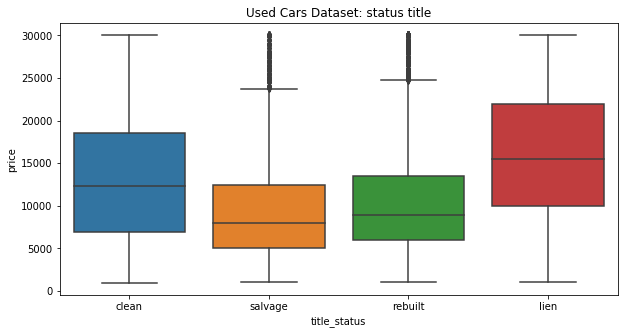

In [18]:
plt.figure(figsize=(10,5))
sns.boxplot(x='title_status',y='price',data=cars).set_title('Used Cars Dataset: status title');

### Fuel Type

Let's take a look at the distribution of prices by fuel type:

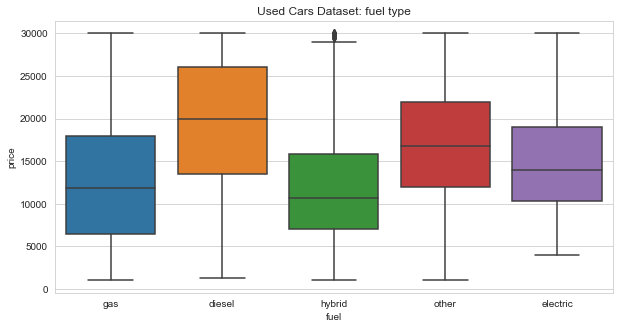

In [19]:
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
sns.boxplot(x='fuel',y='price',data=cars).set_title('Used Cars Dataset: fuel type');

Vehicles with fuel type as  "other" can be removed from the analysis since it would be difficult to identify the fuel to for those:

In [20]:
cars.fuel.value_counts()

gas         274632
diesel       11733
other         8601
hybrid        2783
electric       546
Name: fuel, dtype: int64

In [21]:
cars = cars[~cars['fuel'].isin(['other'])]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 289694

Number of columns 11


### Year

Lets see the number of vehicles grouped by year on a line plot: notice that most vehicles have years between the late 90's and early 2020.

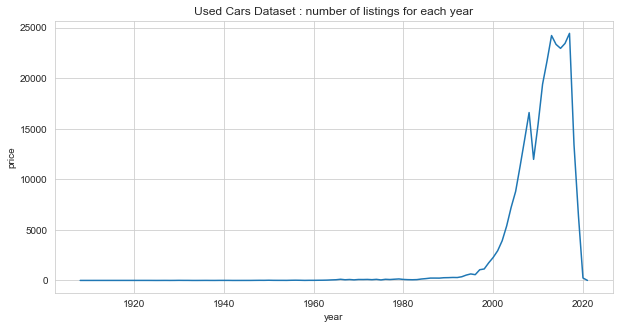

In [22]:
grouped_by_year = cars.groupby('year').count().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='year',y='price',data=grouped_by_year).set_title('Used Cars Dataset : number of listings for each year');

For this analysis we'll look at listings between 1999 and 2019:

In [23]:
cars = cars[(cars.year>=1999) & (cars.year<=2019)]
# dataframe shape
print("Number of rows:",cars.shape[0])
print()
print("Number of columns",cars.shape[1])

Number of rows: 280828

Number of columns 11


### Manufacturer and Model Type

Now let's look at the distribution of manufacturer and model type. 

First, we'll look at the counts of model that occurs at least 500 times in the dataset. 

In [26]:
model_count = pd.DataFrame(cars['model'].value_counts().reset_index())

model_count = model_count[model_count.model>500] # filter above certain value

print("Total number of unique models that occur at least 500 times:",len(model_count))

Total number of unique models that occur at least 500 times: 97


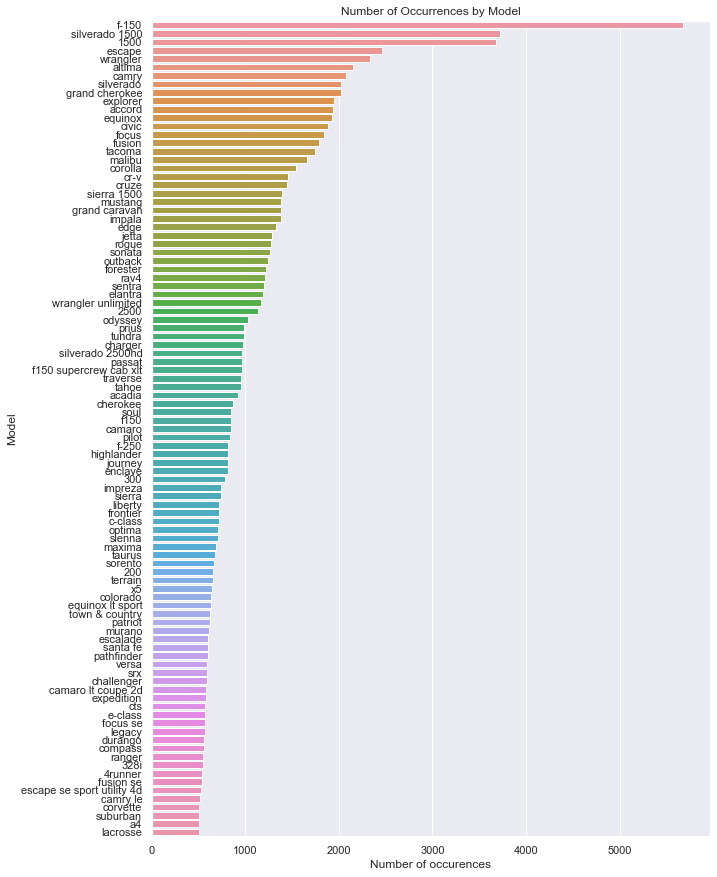

In [28]:
plt.figure(figsize=(10,15))
sns.set()
fig = sns.barplot(x='model',y="index",data=model_count);
fig.set(xlabel="Number of occurences",ylabel="Model",title="Number of Occurrences by Model");

Now we'll look at the number of occurences by manufacturer

In [29]:
manf_count = pd.DataFrame(cars['manufacturer'].value_counts().reset_index())
print("Total number of occurences for each manufacturer:",len(model_count))

Total number of occurences for each manufacturer: 97


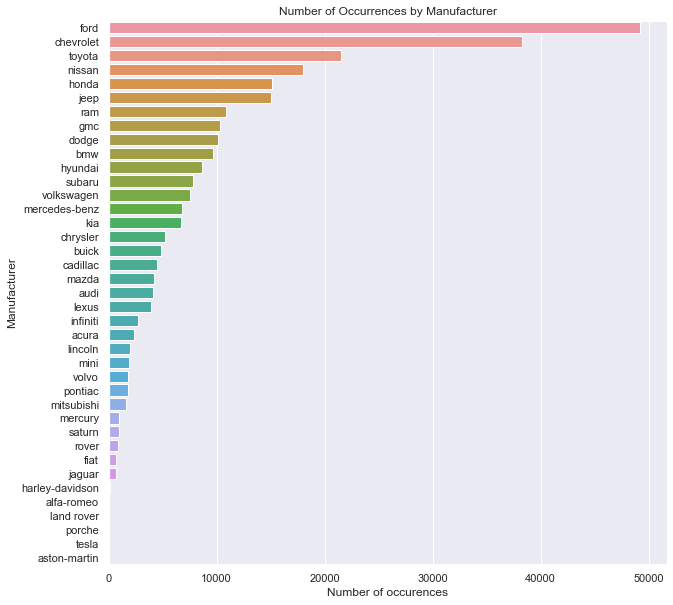

In [30]:
plt.figure(figsize=(10,10))
sns.set()
fig = sns.barplot(x='manufacturer',y="index",data=manf_count);
fig.set(xlabel="Number of occurences",ylabel="Manufacturer",title="Number of Occurrences by Manufacturer");

Based on these two last plots, we'll remove the values of the dataset that have  `model` occurences of at less than 100 times and `manufacturer` occurences of at least 10 times.

In [35]:
cars = cars.groupby('model').filter(lambda x: len(x)>100)
cars = cars.groupby('manufacturer').filter(lambda x: len(x)>10)